In [73]:
using MAT
using PyPlot; plt = PyPlot
using CMF
using LinearAlgebra

In [3]:
path = "/home/asd/data/heart/"

md_groups = matread(path * "groups.mat")
groups = md_groups["groups"]

8-element Array{Any,1}:
 "NSR"      
 "AFIB"     
 "APB"      
 "LBBB"     
 "AFL"      
 "Bigeminy" 
 "Trigeminy"
 "RBBB"     

**Segment training data**

In [31]:
patchsize = 100
patchskip = 50
padsize = 100

trd = Dict()

for num_rows in [1, 64]
    
    train_patches = []
    train_labels = []
    train_user_tags =[]

    for gr in groups
        md_train = matread(
            string(path, "train/", num_rows, gr, ".mat")
        )
                
        labels = md_train["labels"]
        data = md_train["data"]
        breaks = [md_train["breaks"]; size(data, 2)+padsize]
        
        for i = 1:length(labels)
            # Capture segment
            first = breaks[i]
            last = breaks[i+1] - padsize
            segment = data[:, first:last]
            
            # Split segment
            patch_splits = collect(1:patchskip:size(segment, 2)-patchsize)
            
            # Add patches to training data
            for j = 1:length(patch_splits)
                firstp = patch_splits[j]
                lastp = firstp + patchsize
                patch = segment[:, firstp:lastp]
            
                push!(train_patches, patch)
                push!(train_labels, gr)
                push!(train_user_tags, labels[i])
            end
        end
    end
    
    @show length(train_labels)
    
    # Save data
    results = Dict(
            "patches" => train_patches,
            "labels" => train_labels,
            "user_tags" => train_user_tags,
    )
    matwrite(
        string(path, "classify/", num_rows, "train_patches.mat"),
        results
    )
    trd[num_rows] = results
end

length(train_labels) = 3556
length(train_labels) = 3552


**Segment test data**

In [32]:
ted = Dict()

for num_rows in [1, 64]
    
    test_patches = []
    test_labels = []
    test_styles = []
    test_user_tags = []
    
    for gr in groups
        md_test = matread(
            string(path, "test/", num_rows, gr, ".mat")
        )
        
        breaks = md_test["breaks"]
        segs = md_test["segs"]
        user = md_test["user"]
        
        # Split up user
        user_splits = 1:patchskip:size(user, 2)-patchsize
        
        for j = 1:length(user_splits)
            firstp = user_splits[j]
            lastp = firstp + patchsize
            patch = user[:, firstp:lastp]
            
            push!(test_patches, patch)
            push!(test_labels, gr)
            push!(test_styles, "user")
            push!(test_user_tags, 1)
        end
        
        # Split up segments
        for (segkey, seg) in segs
            seg_splits = 1:patchskip:size(seg, 2)-patchsize
            
            for j = 1:length(seg_splits)
                firstp = user_splits[j]
                lastp = firstp + patchsize
                patch = seg[:, firstp:lastp]
                
                push!(test_patches, patch)
                push!(test_labels, gr)
                push!(test_styles, "seg")
                push!(test_user_tags, parse(Int64, segkey[2:end]))
            end
        end
    end
    
    @show length(test_labels)
    
    # Save data
    results = Dict(
            "patches" => test_patches,
            "labels" => test_labels,
            "styles" => test_styles,
            "user_tags" => test_user_tags,
    )
    matwrite(
        string(path, "classify/", num_rows, "test_patches.mat"),
        results
    )
    ted[num_rows] = results
end

length(test_labels) = 934
length(test_labels) = 934


**Evaluate algorithm using CMF**

In [261]:
function compute_scores(patch, motifs, groups; beta=0.5, verbose=false)    
    data = copy(patch)
    if size(patch, 1) > 1  # preprocess spectrograms
        data = data[2:end, :]
        data = log.(data)
        data[isnan.(data) .| isinf.(data)] .= 0
        data .-= sum(data)/length(data)
        data = max.(0, data)
    end
    
    features = []
    loss_scores = []
    sparsity_scores = []
    for W in motifs
        H = evaluate_feature_maps(data, W, l1H=beta)
        push!(loss_scores, CMF.compute_loss(data, W, H))
        push!(sparsity_scores, sum(H))
        push!(features, H)
    end
    
    return loss_scores, sparsity_scores, features
end

mod = Dict()
for num_rows in [1, 64]
    
    # Load motifs
    mod[num_rows] = []
    for gr in groups
        md_results = matread(string(path, "trainout/", num_rows, gr, "_1_30.mat"))
        push!(mod[num_rows], md_results["W"])
    end
end

AFL


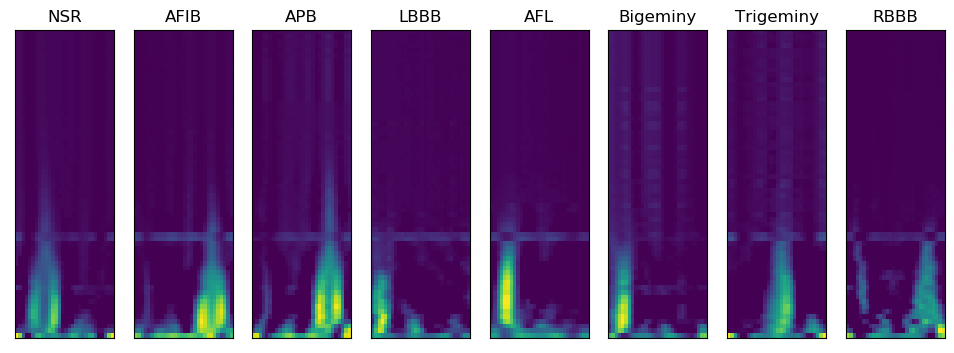

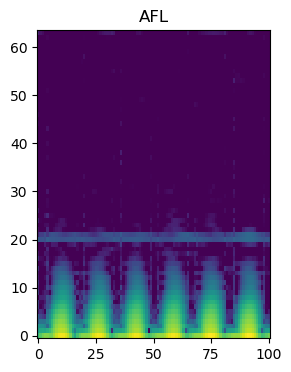

AFL


In [212]:
#### plt.figure()
plt.figure(figsize=(12, 4))
for i = 1:8
    plt.subplot(1, 8, i)
    plt.imshow(mod[64][i][:, :, 1]', origin="lower", aspect="auto")
    plt.title(groups[i])
    plt.yticks([])
    plt.xticks([])
end


k = 504
plt.figure(figsize=(3, 4))
data = copy(ted[64]["patches"][k])
data = data[2:end, :]
data = log.(data)
data[isnan.(data) .| isinf.(data)] .= 0
data .-= sum(data)/length(data)
data = max.(0, data)
plt.imshow(data, origin="lower", aspect="auto")
plt.title(ted[64]["labels"][k])
plt.show()


println(ted[64]["labels"][k])
est, scores = classify(ted[64]["patches"][k], mod[64], groups, weight=0.35, verbose=false)
println(est)


#println(sum(esd[64] .== ted[64]["labels"]) / length(ted[64]["labels"]))

In [291]:
# TODO use training data to set thresholds
# train_lsc = []
# train_ssc = []
# train_feat = []

nrows = 64
patches = trd[nrows]["patches"]
labels = trd[nrows]["labels"]
motifs = mod[nrows]

# @show length(labels)

# for i = 1:length(labels)
#     loss_scores, sparsity_scores, features = compute_scores(patches[i], motifs, groups)
#     push!(train_lsc, loss_scores)
#     push!(train_ssc, sparsity_scores)
#     push!(train_feat, features)

#     if i % 50 == 0
#         print(i, " - ")
#     end
# end

train_class_results = Dict(
    "losses" => train_lsc,
    "sparses" => train_ssc,
    "features" => train_feat,
    "labels" => labels,
)
matwrite(
     string(path, "classify/", nrows, "train_class_results.mat"),
     train_class_results
)
println("Done!")



Done!


In [280]:
# n = length(train_lsc)
# colors = ["g", "r"]
# for (k, gr) in enumerate(groups)
#     losses = [sc[k] for sc in train_lsc[1:n]]
#     sparses = [sc[k] for sc in train_ssc[1:n]]
#     mask = labels[1:n] .== gr
    
#     plt.figure()
#     plt.scatter(losses[.!mask], sparses[.!mask], color="r", s=5)
#     plt.scatter(losses[mask], sparses[mask], color="g", s=5)
#     plt.show()
# end

In [293]:

# Classify test data
test_losses = []
test_sparses = []
test_features = []

nrows = 64
patches = ted[nrows]["patches"]
labels = ted[nrows]["labels"]
motifs = mod[nrows]


for i = 1:length(labels)
    losses, sparses, features = compute_scores(patches[i], motifs, groups)
    
    push!(test_losses, losses)
    push!(test_sparses, sparses)
    push!(test_features, features)
    
    if i % 50 == 0
        print(i, " - ")
    end
end
println("Done.")

test_class_results = Dict(
    "losses" => test_losses,
    "sparses" => test_sparses,
    "features" => test_features,
    "labels" => labels
)
matwrite(
     string(path, "classify/", nrows, "test_class_results.mat"),
     test_class_results
)


50 - 100 - 150 - 200 - 250 - 300 - 350 - 400 - 450 - 500 - 550 - 600 - 650 - 700 - 750 - 800 - 850 - 900 - Done.


In [287]:
keys(test_class_results)

Base.KeySet for a Dict{String,Array{Any,1}} with 3 entries. Keys:
  "features"
  "losses"
  "sparses"